In [9]:
pip install scikit-learn==1.5.2

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install xgboost==2.1.1

Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [12]:
hdb_df = pd.read_csv('/kaggle/input/hdb-dataset/hdb_combined_clean.csv', low_memory=False)

In [13]:
# Split features and target (assuming 'resale_price' is the target)
X = hdb_df.drop(columns=['resale_price'])
y = hdb_df['resale_price']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features (only for models sensitive to scale like linear regression or neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# To calculate adjusted r2 later
n = len(y_test)  
p = X_train_scaled.shape[1]

In [14]:
import joblib 
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [17]:
# Decision Tree Regressor
dt = DecisionTreeRegressor(max_depth= 20, min_samples_leaf=2, min_samples_split=10)
dt.fit(X_train_scaled, y_train)
dt_pred = dt.predict(X_test_scaled)

r_squared = r2_score(y_test, dt_pred)
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
rmse = np.sqrt(mean_squared_error(y_test, dt_pred))
mae = mean_absolute_error(y_test, dt_pred)

print("Decision Tree:")
print(f"  R²: {r_squared:.4f}")
print(f"  Adjusted R²: {adjusted_r_squared:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE: {mae:.4f}")

Decision Tree:
  R²: 0.9735
  Adjusted R²: 0.9735
  RMSE: 27294.1893
  MAE: 18985.2340


In [18]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, min_samples_split=2, max_depth=20)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)

r_squared = r2_score(y_test, rf_pred)
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
mae = mean_absolute_error(y_test, rf_pred)

print("Random Forest:")
print(f"  R²: {r_squared:.4f}")
print(f"  Adjusted R²: {adjusted_r_squared:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE: {mae:.4f}")

Random Forest:
  R²: 0.9801
  Adjusted R²: 0.9801
  RMSE: 23658.8564
  MAE: 16798.8841


In [19]:
# Gradient Boosting Regressor
gb = GradientBoostingRegressor(learning_rate=0.1, n_estimators=300)
gb.fit(X_train_scaled, y_train)
gb_pred = gb.predict(X_test_scaled)

r_squared = r2_score(y_test, gb_pred)
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
mae = mean_absolute_error(y_test, gb_pred)

print("Gradient Boosting:")
print(f"  R²: {r_squared:.4f}")
print(f"  Adjusted R²: {adjusted_r_squared:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE: {mae:.4f}")

Gradient Boosting:
  R²: 0.9630
  Adjusted R²: 0.9630
  RMSE: 32240.6110
  MAE: 23183.9738


In [20]:
# XGBoost Regressor
xgb = XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=300)
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)

r_squared = r2_score(y_test, xgb_pred)
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
mae = mean_absolute_error(y_test, xgb_pred)

print("XGBoost:")
print(f"  R²: {r_squared:.4f}")
print(f"  Adjusted R²: {adjusted_r_squared:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE: {mae:.4f}")

XGBoost:
  R²: 0.9829
  Adjusted R²: 0.9829
  RMSE: 21922.8861
  MAE: 15674.9901


### Stacking

In [21]:
dt_pred = dt.predict(X_test_scaled)
rf_pred = rf.predict(X_test_scaled)
gb_pred = gb.predict(X_test_scaled)
xgb_pred = xgb.predict(X_test_scaled)

In [22]:
# Combine the predictions of the base models into a single feature matrix
X_test_meta = np.column_stack((dt_pred, rf_pred, gb_pred, xgb_pred))

# Train the meta-model on the combined feature matrix and the target values
meta_model = LinearRegression()
meta_model.fit(X_test_meta, y_test)

LinearRegression()

In [23]:
# Make predictions on new data
dt_pred_new = dt.predict(X_test_scaled)
rf_pred_new = rf.predict(X_test_scaled)
gb_pred_new = gb.predict(X_test_scaled)
xgb_pred_new = xgb.predict(X_test_scaled)

# Combine the predictions of the base models into a single feature matrix
X_new_meta = np.column_stack((dt_pred_new, rf_pred_new, gb_pred_new, xgb_pred_new))

# Make a prediction using the meta-model
y_new_pred = meta_model.predict(X_new_meta)

r_squared = r2_score(y_test, y_new_pred)
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
rmse = np.sqrt(mean_squared_error(y_test, y_new_pred))
mae = mean_absolute_error(y_test, y_new_pred)

print(f"  R²: {r_squared:.4f}")
print(f"  Adjusted R²: {adjusted_r_squared:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE: {mae:.4f}")

  R²: 0.9830
  Adjusted R²: 0.9830
  RMSE: 21831.7990
  MAE: 15587.6885


In [24]:
import joblib

# Save the meta-model
joblib.dump(meta_model, 'meta_model.pkl')

# Save the base models 
joblib.dump(dt, 'decision_tree_model.pkl')
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(gb, 'gradient_boosting_model.pkl')
joblib.dump(xgb, 'xgboost_model.pkl')
xgb.save_model('xgb_model.json')  # You can also use .bin extension if preferred

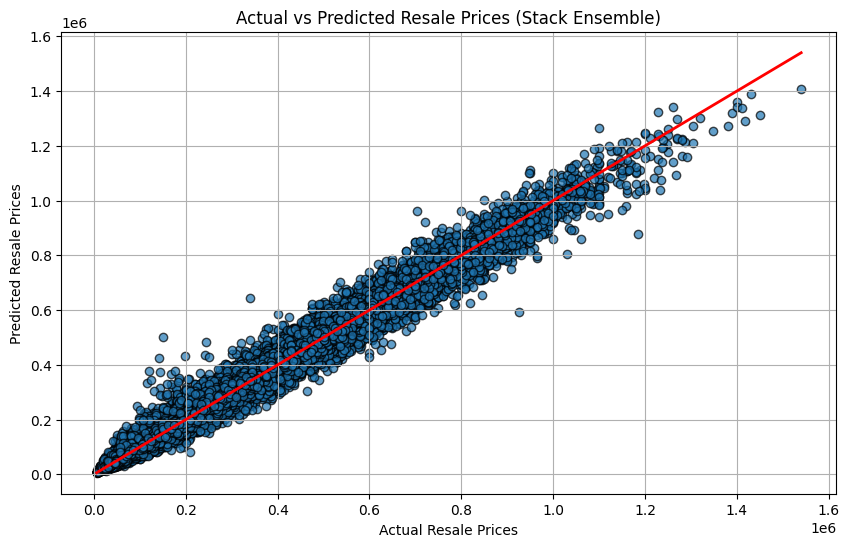

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_new_pred, edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Diagonal line (perfect predictions)
plt.title('Actual vs Predicted Resale Prices (Stack Ensemble)')
plt.xlabel('Actual Resale Prices')
plt.ylabel('Predicted Resale Prices')
plt.grid(True)
plt.show()

In [26]:
train_feature_names = X_train.columns.tolist()
print(train_feature_names)

['floor_area_sqm', 'nearest_supermarket_distance', 'nearest_school_distance', 'nearest_mrt_distance', 'nearest_hawkers_distance', 'cbd_distance', 'year_of_sale', 'calculated_remaining_lease', 'storey_median', 'town_BEDOK', 'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH', 'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA', 'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG', 'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA', 'town_LIM CHU KANG', 'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL', 'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON', 'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN', 'flat_type_2 ROOM', 'flat_type_3 ROOM', 'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE', 'flat_type_MULTI GENERATION', 'flat_model_3Gen', 'flat_model_Adjoined flat', 'flat_model_Apartment', 'flat_model_DBSS', 'flat_model_Improved', 'flat_model_Improved-Maisonette', 'flat_model_Maisonette', 'f